# Carbon Chain (Part 2)

This example demonstrates the calculations of charge current, spin torque, and interfacial spin current for a two-probe carbon chain. Unlike the first example, this device is subject to an electrical bias of 0.1 V.

## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import junpy as jp
from junpy.factory import nanodcal
from junpy.experiment.extend_center_2 import extend_center
%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.rc = {'font.size': 12}

## Load Device

In order to observe the variation of the spin torque and interfacial spin current beyond the central region, we can include the electrode atoms into the central region using the `extend_center` function. `repeatL` and `repeatR` specify the repetition multiples of the left and right electrodes, respectively.

In [2]:
filename = (
    'jpdataset/nanodcal/twoprobe_carbon_chain/'
    'LDA_NC_dC-3.0-ang/sys_6C-vac5ang-6C_zx0-zx90/v0.10/NanodcalStructObject.mat')
device = nanodcal.load_nanodcal_device(filename)
device_ext = extend_center(device, repeatL=3, repeatR=3)

## Calculate Charge Current

We first calculate the charge current using the Landau's formula. `jp.BiasWindow(interval=0.005)` specifies that the energy integral is in the bias window and the interval is `0.005`.

In [3]:
calcr = jp.Current(
    device=device,
    energies=jp.BiasWindow(interval=0.005),
    etaSigma=1e-6,
    etaGF=0)
jp.run(calcr, savefile=False)

JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset
Calculating current... (2024-08-15 20:30:08)
    Device information
        bias (mu2-mu1)--------------------------: 0.10000001031619467
        central.numberOfSites-------------------: 12
        central.spinType------------------------: SpinType.GeneralSpin
        lead1.numberOfSites---------------------: 3
        lead1.spinType--------------------------: SpinType.GeneralSpin
        lead1.direction-------------------------: -3
        lead1.temperature-----------------------: 0.0
        lead1.chemicalPotential-----------------: -0.0
        lead2.numberOfSites---------------------: 3
        lead2.spinType--------------------------: SpinType

The `[calcr].current` function returns the calculated value.

In [4]:
current = calcr.current(spin="sum")
print(f'The charge current is {current} ampere.')

The charge current is [3.79142962e-08] ampere.


## Calculate Spin Torque

We use the `jp.SpinTorque` class to build a calculation for spin torque. `nonequilibriumEnergies` specifies the energy sampling for integrating the real-axis energy for the Green's function. `equilibriumEnergies` specifies the energy sampling for integrating the complex contour energy for the Green's function. `circlePoints` is the number of points, and `lowestEnergy` is the starting point for the lowest energy. `spinAccumulationDetail` specifies whether to compute the spin accumulation or not.

In [5]:
calcr_st = jp.SpinTorque(
    device=device_ext,
    nonequilibriumEnergies=jp.BiasWindow(interval=0.005),
    equilibriumEnergies=dict(
        circlePoints=30,
        lowestEnergy=-30),
    spinAccumulationDetail=True)
jp.run(calcr_st, savefile=False)

JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset
Calculating spin torque... (2024-08-15 20:30:17)
    Device information
        bias (mu2-mu1)--------------------------: 0.10000001031619467
        central.numberOfSites-------------------: 30
        central.spinType------------------------: SpinType.GeneralSpin
        lead1.numberOfSites---------------------: 3
        lead1.spinType--------------------------: SpinType.GeneralSpin
        lead1.direction-------------------------: -3
        lead1.temperature-----------------------: 0.0
        lead1.chemicalPotential-----------------: -0.0
        lead2.numberOfSites---------------------: 3
        lead2.spinType--------------------------: Spin

In this example, we have 30 atoms in the extended central region. We create an array `sites` to label them:

In [6]:
sites = np.arange(0, 30)

The `[calcr].spin_torque` function returns the computed spin torque values. The `hamiltonian` parameter specifies the Hamiltonian used for computing the spin torque. Possible values are `'full'` (default), `'H0'`, `'Hxc'`, and `'Hso'`. Note that `'Hxc'` and `'Hso'` correspond to the exchange spin torque ($T^\mathrm{XC}$) and spin-orbit torque ($T^\mathrm{SO}$), respectively.

In [7]:
# shape: (#kpoints, #energies, #sites, #spin)
st = calcr_st.spin_torque(hamiltonian='Hxc')
# shape: (#sites, #spin)
st = st[0,0]

We exclude the boundary atoms using `[3:-3]` to remove the uncalculated boundary results:

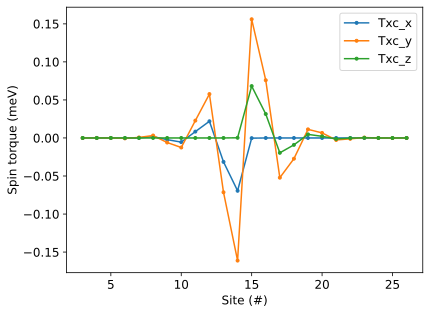

In [8]:
plt.plot(sites[3:-3], st[3:-3,0]*1e3, '.-', label='Txc_x')
plt.plot(sites[3:-3], st[3:-3,1]*1e3, '.-', label='Txc_y')
plt.plot(sites[3:-3], st[3:-3,2]*1e3, '.-', label='Txc_z')
plt.xlabel('Site (#)')
plt.ylabel('Spin torque (meV)')
plt.legend()
plt.show()

The `[calcr].spin_accumulation` function is used to retrieve the computed spin accumulation values ($\Phi$).

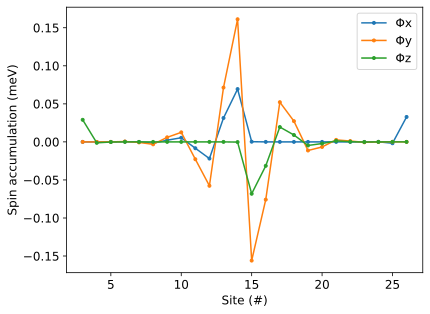

In [10]:
# shape: (#kpoints, #energies, #sites, #spin)
sa = calcr_st.spin_accumulation()
# shape: (#sites, #spin)
sa = sa[0,0]

plt.plot(sites[3:-3], sa[3:-3,0]*1e3, '.-', label='$\Phi$x')
plt.plot(sites[3:-3], sa[3:-3,1]*1e3, '.-', label='$\Phi$y')
plt.plot(sites[3:-3], sa[3:-3,2]*1e3, '.-', label='$\Phi$z')
plt.xlabel('Site (#)')
plt.ylabel('Spin accumulation (meV)')
plt.legend()
plt.show()

## Calculate Interfacial Spin Current

For comparison, we also compute the interfacial spin current using the `jp.SpinCurrent` class.

In [12]:
calcr_sc = jp.SpinCurrent(
    device=device_ext,
    nonequilibriumEnergies=jp.BiasWindow(interval=0.005),
    equilibriumEnergies=dict(
        circlePoints=30,
        lowestEnergy=-30))
jp.run(calcr_sc, savefile=False)

JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset


Calculating spin current... (2024-08-15 20:38:09)
    Device information
        bias (mu2-mu1)--------------------------: 0.10000001031619467
        central.numberOfSites-------------------: 30
        central.spinType------------------------: SpinType.GeneralSpin
        lead1.numberOfSites---------------------: 3
        lead1.spinType--------------------------: SpinType.GeneralSpin
        lead1.direction-------------------------: -3
        lead1.temperature-----------------------: 0.0
        lead1.chemicalPotential-----------------: -0.0
        lead2.numberOfSites---------------------: 3
        lead2.spinType--------------------------: SpinType.GeneralSpin
        lead2.direction-------------------------: 3
        lead2.temperature-----------------------: 0.0
        lead2.chemicalPotential-----------------: 0.10000001031619467
    Energy sampling (equilibrium)
        samplingName----------------------------: SemiCircleContourEnergySampling
        range--------------------

Given that the central region consists of 30 atoms aligned along the $z$ axis, there are 29 interfaces. The `[calcr].interfacial_spin_current` function returns the electron current in units of eV. The spin currents, `Qx`, `Qy`, and `Qz`, correspond to the projections onto the Pauli matrices $\sigma_x$, $\sigma_y$, and $\sigma_z$, respectively. `Q0` represents the total current, obtained by summing the spin-up and spin-down components, which is equivalent to projecting onto $\sigma_0$.

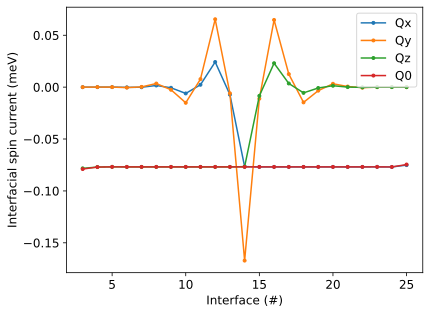

In [13]:
# #interfaces = #sites - 1
interfaces = np.arange(0, 29)
# shape: (#interfaces, #spin)
isc = calcr_sc.interfacial_spin_current()

plt.plot(interfaces[3:-3], isc[3:-3,1]*1e3, '.-', label='Qx')
plt.plot(interfaces[3:-3], isc[3:-3,2]*1e3, '.-', label='Qy')
plt.plot(interfaces[3:-3], isc[3:-3,3]*1e3, '.-', label='Qz')
plt.plot(interfaces[3:-3], isc[3:-3,0]*1e3, '.-', label='Q0')
plt.xlabel('Interface (#)')
plt.ylabel('Interfacial spin current (meV)')
plt.legend()
plt.show()

We also convert the electron current to the charge current in units of amperes by multiplying by $-2e/\hbar$. Note that the almost constant value of charge (`I0=3.74e-8`) is close to the value calculated by `jp.Current`.

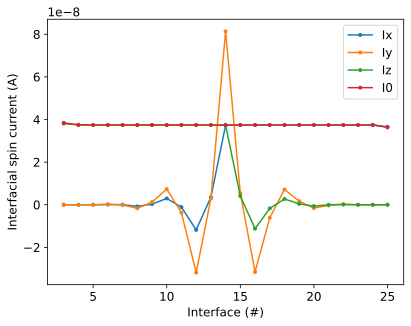

In [14]:
isc2 = isc*(-1*jp.util.E2OVERHBAR)
plt.plot(interfaces[3:-3], isc2[3:-3,1], '.-', label='Ix')
plt.plot(interfaces[3:-3], isc2[3:-3,2], '.-', label='Iy')
plt.plot(interfaces[3:-3], isc2[3:-3,3], '.-', label='Iz')
plt.plot(interfaces[3:-3], isc2[3:-3,0], '.-', label='I0')
plt.xlabel('Interface (#)')
plt.ylabel('Interfacial spin current (A)')
plt.legend()
plt.show()

The gradient of the interfacial spin current should yield the results of spin accumulation. One can compare with the results from the `[calcr].spin_accumulation` calculation above.

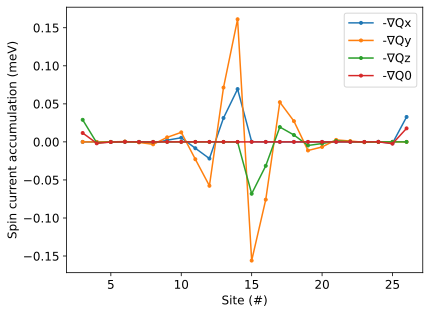

In [15]:
# shape: (#sites-2, #spin)
isca = -np.diff(isc, axis=0)

plt.plot(sites[3:-3], isca[2:-2, 1]*1e3, '.-', label=r'-$\nabla$Qx')
plt.plot(sites[3:-3], isca[2:-2, 2]*1e3, '.-', label=r'-$\nabla$Qy')
plt.plot(sites[3:-3], isca[2:-2, 3]*1e3, '.-', label=r'-$\nabla$Qz')
plt.plot(sites[3:-3], isca[2:-2, 0]*1e3, '.-', label=r'-$\nabla$Q0')
plt.xlabel('Site (#)')
plt.ylabel('Spin current accumulation (meV)')
plt.legend()
plt.show()